# Discrete Distributions I
DA Probability & Statistics Learning Series • 📚.3.2

<br>
<img src="https://miro.medium.com/max/1200/0*vEU2404dGwUgbidl.jpg" />
<br>

Welcome!

*See **#da_prob_stat** for discussion during and after this tutorial.*

### Goals

- Reinforce our familiarity and comfort with the new mathematical objects we introduced last time: **random variables** and their **distributions**
- Introduce **expectation** and lay the groundwork for generalizing across all \[discrete\] distributions
- Intuit and characterize the **Hypergeometric** distribution and connect it to the **Binomial** by reexamining Christy Wong's lunchtime habits 🍲

*We may break this session into multiple parts depending on how far we get given our time constraints.*


In [1]:
# Autoreload changes to custom
%load_ext autoreload
%autoreload 2

# Sharpen matplotlib plots
%config InlineBackend.figure_format = 'retina'

In [2]:
# Import dependencies 
from custom.db_utils import get_connection
import pandas as pd

# Analysis
import scipy.stats
import numpy as np

# Data viz
import matplotlib.pyplot as plt

## Warm Up 🤔

First, let's think through the homework question I posed at the end of the last lesson (📚.3.1):

<br>

> Find an example of two discrete random variables $X$ and $Y$ (on the same sample space) such that $X$ and $Y$ have the same distribution (i.e., same PMF and same CDF), but the event $X = Y$ never occurs.

Hints: 

- Think about a very, very simple discrete distribution like the Bernoulli. What can we model with it?

- How might _any_ two events be mutually exclusive but equally likely (i.e., $P(X=x) = P(Y=y)$ for all $x$, and $y$, but $X \neq Y$)?

- Let's fix our distribution that $X$ and $Y$ share: let's say it's uniform (so all events are equally likely).

**Answer**:

> Let $X$ and $Y$ be distributed $\text{Bern}(0.5)$ whereby $X$ indicates a fair coin that lands 'heads' upon being flipped and $Y$ indicates the coin landing 'tails.' Hence, $X$ = $1 - Y$.

This is but one possible answer! For you to ponder: what would be another example?

## Review ⏪

Remember the big picture that we've developed thus far?

![The Big Picture](./end_goal.png)

### Characterizing Discrete Distributions

Pebble World analogues can carry us pretty far in understanding their mathematical counterparts. We can continue extending that analogy with distributions.

Working with events:

| Pebble World | Math Terminology | Notation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;
|:-----:|:-----:|:----------------------:|
| box of pebbles | sample space | $S$
| 1 pebble | outcome | $s$
| 1+ pebbles | event | $A = \{s_{1}, s_{9}\}$
| mass of pebble(s) | probability | $P(A)$

When we consider an event $X=x$, it's really just shorthand for $X(s) = x$. **Random variables are functions that take a pebble and return (map to) a number**.

![Grouping Pebbles](./grouping_pebbles.png)

So now, we can extend our mental cheatsheet:

| Pebble World | Math Terminology | Notation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;
|:-----:|:-----:|:----------------------:|
| pebble label type | random variable | $X$, $Z$, $Y$
| pebble label value | numerical value  | $x$, $z$, $y$
| 1+ pebbles | event | $X = x$, $Z \gt 3$, $Y \leq k$
| mass of pebble(s) | probability | $P(X = x)$, $P(Z \gt 3)$, $P(Y \leq k)$

### The Bernoulli

When we looked at the Bernoulli distribution, we noticed that it was the simplest discrete distribution. It models an event happening / not happening by assigning probabilities associated with the event and its complement to $0$ and $1$, respectively.

Letting $X \sim \text{Bern}(p)$, we can say the PMF of $X$ is:

$$
f(k) = P(X=k) =\begin{cases}q=1-p&{\text{if }}k=0\\p&{\text{if }}k=1\end{cases}
$$

**Reminder**: The *support* of a distribution are the *events* (which are just numbers!) that have a non-zero probability. Immediately, we see that the support for a Bernoulli is $\{0,1\}$ for $0\lt p \lt 1$.



In [3]:
# Get the database connection and cursor objects
conn, cur = get_connection()

# Use a context manager to open and close connection and files
with conn:
    
    # Open the query.sql file
    with open('invoicing_otp.sql', 'r') as q:

        # Save contents of query.sql as string
        query_str = q.read()
    
    # Use the read_sql method to get the data from Snowflake into a 
    # Pandas dataframe
    df = pd.read_sql(query_str, conn)
    
    # Make all the columns lowercase
    df.columns = map(str.lower, df.columns)

# Preview the data
df.sample(3)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


,invoice_id,invoice_shared_at,share_due_at,is_invoiced_on_time,days_to_share
8751,741527,2020-06-11 23:46:01.680737,2020-06-13 15:30:00+00:00,True,-1.6555
61662,736052,2020-06-05 01:52:41.095653,2020-06-01 18:07:00+00:00,False,3.3234
63104,866198,2020-08-18 16:57:25.361480,2020-08-16 17:32:00+00:00,False,1.9760


In [4]:
# Step-function plot function
def plot_step(x,y, ax=None, where='post', **kwargs):
    '''
    Returns step function plot on ax
    '''
    assert where in ['post', 'pre']
    x = np.array(x)
    y = np.array(y)
    if where=='post':
        y_slice = y[:-1]
    if where=='pre': 
        y_slice = y[1:]
    X = np.c_[x[:-1], x[1:], x[1:]]
    Y = np.c_[y_slice, y_slice, np.zeros_like(x[:-1])*np.nan]
    if not ax: 
        ax=plt.gca()
    return ax.plot(X.flatten(), Y.flatten(), **kwargs)

def bernoulli_xtick_labeler(tick_val, tick_pos):
    if int(tick_val) in [0,1]:
        return int(tick_val)
    else:
        return ''

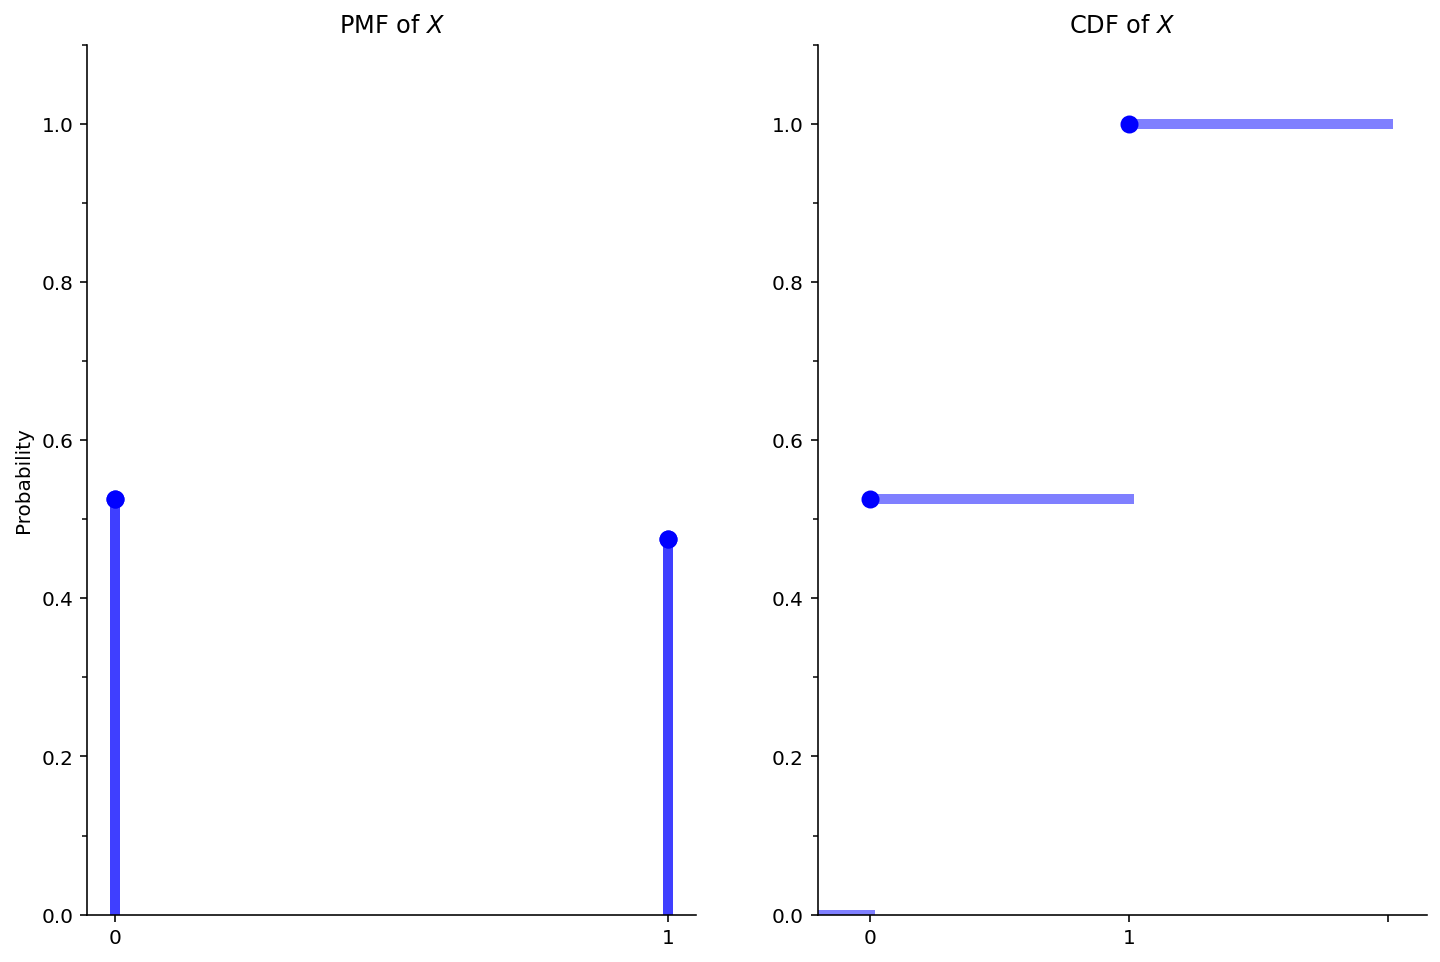

p = 47.45% invoices are invoiced on time
q = 52.55% invoices are NOT invoiced on time


In [5]:
from scipy.stats import bernoulli
from matplotlib.ticker import FuncFormatter, MaxNLocator, MultipleLocator

# Random variable X is distributed Bern(p)
p = df['is_invoiced_on_time'].mean()
x = np.array([0,1])
# x = np.arange(bernoulli.ppf(0.01, p),
#               bernoulli.ppf(0.99, p))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12,8))

for i, ax in enumerate(axes):

    # Plot the PMF
    if i == 0:
        ax.plot(x, bernoulli.pmf(x, p), 'bo', ms=8, label='PMF of $X$')
        ax.vlines(x, 0, bernoulli.pmf(x, p), colors='b', lw=5, alpha=0.5)
        ax.plot(1-x, bernoulli.pmf(1-x, p), 'bo', ms=8)
        ax.vlines(1-x, 0, bernoulli.pmf(1-x, p), colors='b', lw=5, alpha=0.5)
        ax.set_ylabel('Probability')
        ax.title.set_text('PMF of $X$')
    else:
        plot_step([-1,0,1,2], [0,1-p,1,1], color='b', lw=5, alpha=0.5, label='CDF of $X$')
        ax.plot(0, 1-p, 'bo', ms=8)
        ax.plot(1, 1, 'bo', ms=8)
        ax.title.set_text('CDF of $X$')
        ax.set_xlim(left=-.2)

    # Styling
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_ylim(0, 1.1)
    
    # Axis ticks, labels
    ax.xaxis.set_major_formatter(FuncFormatter(bernoulli_xtick_labeler))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.tick_params(which='minor', width=0.75, length=2.5, labelsize=10)

plt.show()

print(f"p = {p:.2%} invoices are invoiced on time")
print(f"q = {1-p:.2%} invoices are NOT invoiced on time")

### The Binomial

The best way to remember these named distributions is to associate them with a story. The Bernoulli is often framed as flipping a coin. We can extend this story to reflect what the Binomial is.

**Question**: 

> What "story" can I tell to explain the Binomial?

Hint: What distribution is equivalent to $\text{Bin}(1,p)$?

**Answer**:

> Let $n$ people each flip a coin that has a probability $p$ of landing 'heads.' Count the number of 'heads.'

Translating this story into math, we say the Binomial is the distribution of the sum of $n$ independent random variables distributed $\text{Bern}(p)$.

With this story in mind, we can directly characterize the Binomial's PMF. Letting $X \sim \text{Bin}(n,p)$, we can say the PMF of $X$ is:

$$
f(k)= P(X=k) = \binom{n}{k}p^{k}q^{n-k}
$$

**Question**:

> Let's say 10 independent invoices get logged. What the probability that 7 or more are on-time? Assume $p$ from our calculations above / last time.

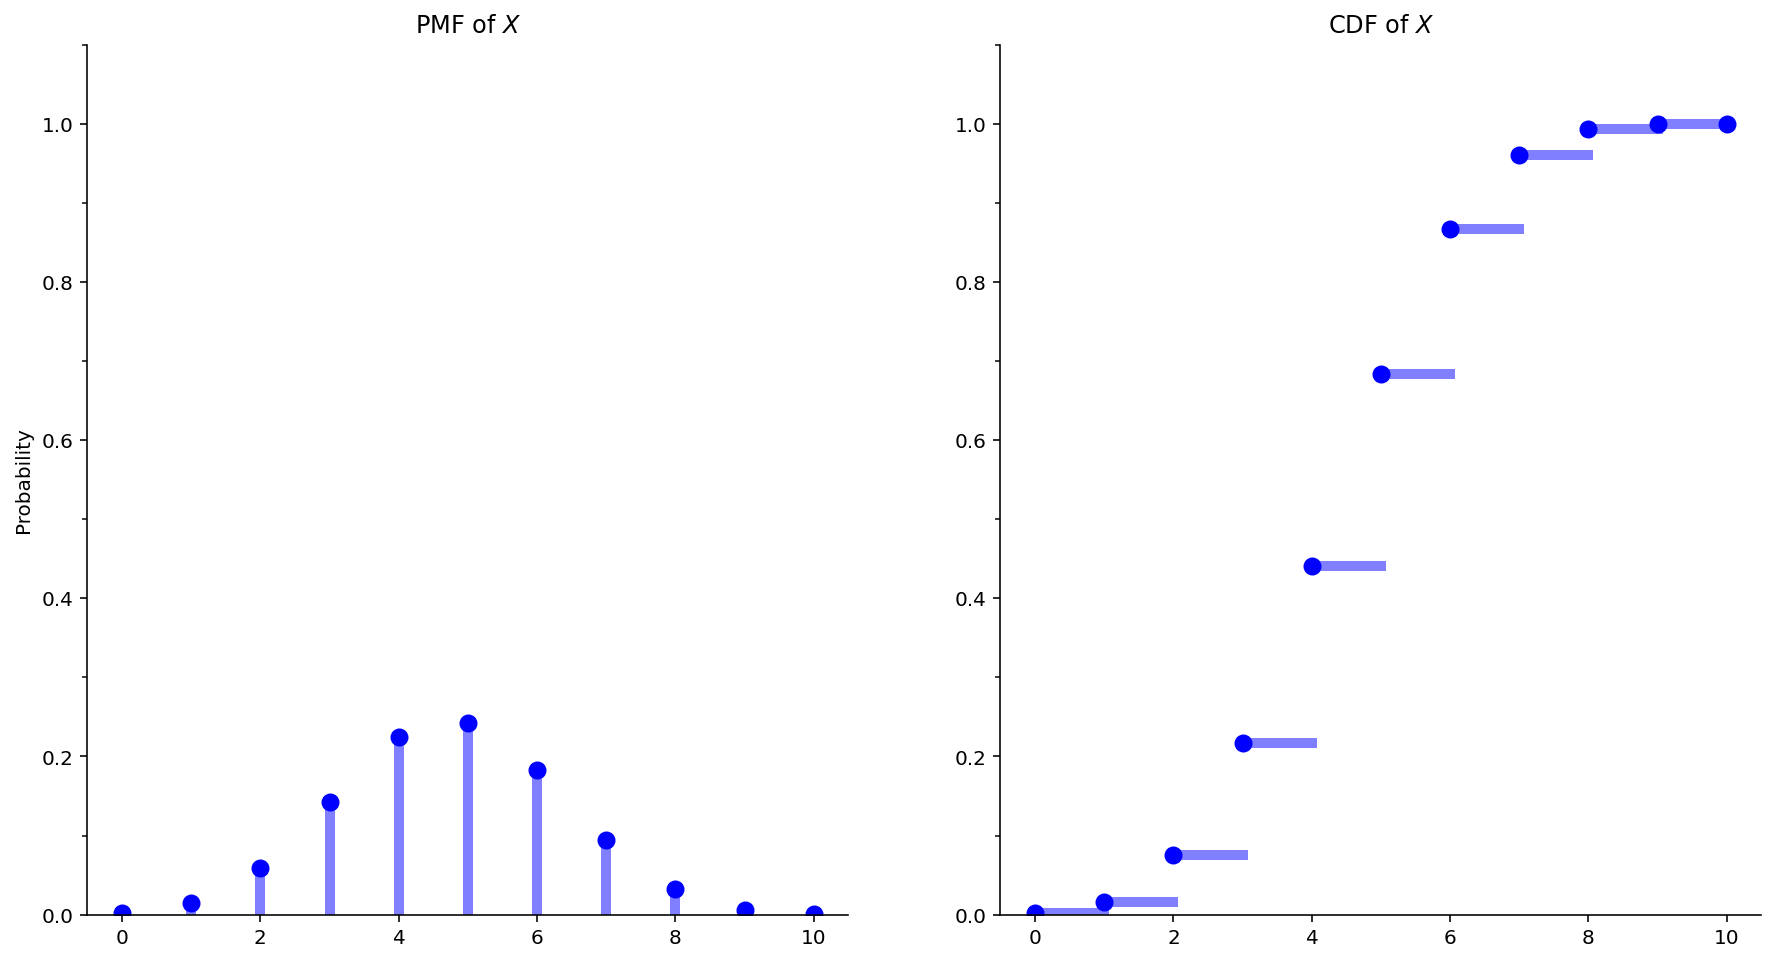

13.32% chance 7+ invoices (of 10) are on-time


In [6]:
from scipy.stats import binom

# Random variable X is distributed Bin(n,p)
n = 10
x = np.arange(0,n+1)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15,8))

for i, ax in enumerate(axes):

    # Plot the PMF
    if i == 0:
        ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='PMF of $X$')
        ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)
        ax.set_ylabel('Probability')
        ax.title.set_text('PMF of $X$')
    else:
        plot_step(x, binom.cdf(x, n, p), color='b', lw=5, alpha=0.5, label='CDF of $X$')
        for i, prob in enumerate(binom.cdf(x, n, p)):
            ax.plot(x[i], prob, 'bo', ms=8)
        ax.title.set_text('CDF of $X$')

    # Styling
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_ylim(0, 1.1)
    
    # Axis ticks, labels
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.tick_params(which='minor', width=0.75, length=2.5, labelsize=10)

plt.show()

print(f"{1 - binom.cdf(x, n, p)[6]:.2%} chance 7+ invoices (of {n}) are on-time")

**Answer**:

> The CDF of $X$ is $P(X \leq x)$. To compute the probability of the event we care about (i.e., $7$+ invoices are on-time), we can take the complement of the event we don't care about, which is the CDF evaluated at $6$: $P(X \geq 7) = 1 - P(X \leq 6)$.

**Question**:

> What's the distribution of $X+Y$ if $X \sim \text{Bin}(n,p)$, $Y \sim \text{Bin}(m,p)$, and $X$ and $Y$ are independent?

Hint: Think about what Binomial random variables count. 

**Answer**:

> $X+Y \sim \text{Bin}(n+m, p)$. The proof is immediate from the story of the Binomial!

You actually have all of the tools to prove this algebraically, too. Using *LOTP* and *independence* and by recognizing Vandermonde's Identity (story: choosing a team of size $k$ from a group consisting of $m$ men and $n$ women), the proof is as follows:

\begin{align}
P(X+Y=k) &= \sum_{j=0}^{k} P(X+Y=k|X=j) P(X=j)\\
&= \sum_{j=0}^{k} P(Y=k-j) P(X=j)\\
&= \sum_{j=0}^{k} \binom{m}{k-j}p^{k-j}q^{m-k+j} \binom{n}{j}p^{j}q^{n-j}\\
&= p^{k}q^{n+m-k} \sum_{j=0}^{k} \binom{m}{k-j} \binom{n}{j}\\
&= \binom{n+m}{k}p^{k}q^{n+m-k}
\end{align}

## Expectation 𝔼

### Take 1 🎬

**Question**:

> What's the *average* of $X$ if $X \sim \text{Bern}(p)$?

We...

...write $\mathop{E}(X)$ or $\mathop{\mathbb{E}}X$.

...say we're taking the "expectation of $X$" or the "expected value of $X$" or the "mean of $X$."

**Answer**:

> $\mathop{\mathbb{E}}X = 0q + 1p = p$

![Center of Mass](expectation_center_of_mass.png)

In physics, **the center of mass** is an analogous concept to expectation. Consider a weightless rod on which are placed weights, at locations $x_{i}$ along the rod and having masses $p_{i}$ (whose sum is one). The point at which the rod balances is $\mathbb{E}X$.

But where did $0q + 1p$ come from? And how did we know this was equal to $\mathbb{E}X$?

The definition of **expectation** for a discrete random variable is inspired by the weighted mean of a list of numbers, with weights given by probabilities.

For distributions with *countably infinite* supports, expectation is the infinite sum:

$$
E(X) = \sum_{j=1}^{\infty} x_{j} P(X = x_{j})
$$

For distributions with *countably finite* supports, expectation is the sum given over all of its support:

$$
\begin{align}
E(X) = \sum_{x}^{} \underbrace{x}_{\text{value}} \underbrace{P(X = x)}_{\text{PMF at }x}
\end{align}
$$


### Linearity of Expectation

We need a spreadsheet jock to jump into this [spreadsheet](https://docs.google.com/spreadsheets/d/1a1y4k6x8ZpKNofz-mdb02tjQOrQJGdyDrHPx9_uxvRI/edit?usp=sharing) to help us fully grasp the properties of expectation, including the very, very powerful property of **linearity**.

We can now define (formally) *linearity of expectation*:

For any random variables $X$, $Y$ and any constant $c$,

$$
E(X + Y) = E(X) + E(Y),\\
E(cX) = cE(X)
$$

**Questions**: 

> How can we prove linearity of expectation, i.e., $E(X) + E(Y) = E(X+Y)$, especially if $X$ and $Y$ are on the same sample space?

Hint 1: Think about Pebble World. (Always a good idea.)\
Hint 2: Think about *grouped* vs. *ungrouped* ways of averaging.

> How would we compute $\mathbb{E}X^{2}$?

Hint 1: A function of a function is a function. A random variable is a function. A function of a random variable is...?\
Hint 2: Refer back to that [spreadsheet](https://docs.google.com/spreadsheets/d/1a1y4k6x8ZpKNofz-mdb02tjQOrQJGdyDrHPx9_uxvRI/edit?usp=sharing).

*Note*: We won't explicitly answer these here in the notebook, but can discuss (time permitting).

### The Fundamental Bridge

That may seem excruciatingly simple, but the connection between events and random variables is established with the expectation of a Bernoulli random variable. 

Let random variable $I_{A}$ be the indicator random variable for event $A$. That is, when $A$ occurs $I_{A}=1$ and when $A$ doesn't occur, $I_{A}=0$. Then, from what we know about Bernoulli distributions, we can say:

$$
P(A) = \mathop{E}(I_{A})
$$


This is **The Fundamental Bridge**. This seems very trivial, but as we'll see later, the implications are enormous!

### Take 2 🎬

**Question**:

> What's the *average* of $X$ if $X \sim \text{Bin}(n,p)$?

Hint: Think about the "story" of the Binomial.

**Answer**:

> $\mathop{\mathbb{E}}X = np$

If we have the sum of $n$ *independent and identically distributed* (commonly, simply stated $\text{i.i.d}$) Bernoulli trials with each trial having a probability $p$ of success, we should expect $\sum_{i=1}^{n} p = np$ successes on average (by *linearity of expectation*)!

## The Hypergeometric

As I said before, it's a good idea to associate distributions with stories. I hope that you will forever be unable to disentangle the Hypergeometric distribution from Christy Wong's affinity for soup.

In 🤏.1, we needed some sort of test to determine if there was substantially enough evidence that Christy's propensity to opt for soup at lunch vs. other Flexporters based on the data we collected on her and others. We used a **Wald Test** then and we had already introduced the **$\chi^2$ Test of Independence** in 📚.2.1. We're closing the loop on this today with **Fisher's Exact Test**.

Following Christy for 60 more days yields the following contingency table:

In [7]:
# Set random seed 
np.random.seed(2020)

# Fabricate data on soup eating (drinking?) habits
params = dict(Christy=0.9, Others=0.1)
soup_data = pd.DataFrame({k: np.random.choice([0,1], 60, replace=True, p=[1-v, v]) 
                      for k, v in params.items()}).melt(value_name='soup_indicator', 
                                                        var_name='predictor')

# Build 2x2 contingency table
soup_abs_freq = pd.crosstab(soup_data['predictor'], soup_data['soup_indicator'], margins=True)
soup_abs_freq

soup_indicator,0,1,All
predictor,,,
Christy,3,57,60
Others,51,9,60
All,54,66,120


Let's think about how we'd want to construct a test with these data and the discrete distributions we've covered so far.

**Question**: 

> What would be a good candidate *parameter* to test? What should our null hypothesis be?

Hint: What parameters have we seen so far with the Bernoulli and the Binomial?

**Answer**:

> We should consider $p$, the probability of choosing soup for lunch. If we let $p_{\text{Christy}}$ be the probability Christy gets soup and $p_{\text{non-Christy}}$ be the probability someone who's not Christy gets soup, our null hypothesis should be $p_{\text{Christy}} = p_{\text{non-Christy}}$.

Cool. Now let's create two random variables, $X$ and $Y$, which count the number of times Christy and non-Christys get soup, respectively.

**Question**:

> How can we model $X$ and $Y$ with the distributions we've seen so far?

Hint: We have $60$ days of data on the two groups and we already established $p_{\text{Christy}}$ and $p_{\text{non-Christy}}$.

**Answer**:

> Let $X \sim \text{Bin}(60, p_{\text{Christy}})$ and $Y \sim \text{Bin}(60, p_{\text{non-Christy}})$, independently.

Now we don't know the *true* parameters, but we do have data that we collected and we have our null hypothesis that says these $p$ are the same. 

In [8]:
# Contingency table
soup_abs_freq

soup_indicator,0,1,All
predictor,,,
Christy,3,57,60
Others,51,9,60
All,54,66,120


Like all of the other statistical tests we've done, we want to see how our data stacks up -- does it exhibit enough funkiness that the null hypothesis becomes implausible?

So, with a fixed number of observations of soup lunches ($X+Y = 66$), we are left asking **how likely is it that Christy had 57 soup lunches *given* we saw 66 soup lunches in total**?

Yep. It's time to use one of our oldest techniques: **conditioning**.

We can translate our question, "**How likely is it that Christy had 57 soup lunches *given* we saw 66 soup lunches in total**?" into a conditional probability: $P(X=57 | X+Y=66)$.

**Question**: 

> How can we calculate this conditional probability?

**Answer**:

> Bayes Rule!
>
> $$
P(X=57|X+Y=66) = \frac{P(X+Y=66|X=57)P(X=57)}{P(X+Y=66)}
$$

We can use what we know about **independence** and the PMFs of Binomials to actually compute this conditional probability:

$$
\begin{align}
P(X=57|X+Y=66) &= \frac{P(X+Y=66|X=57)P(X=57)}{P(X+Y=66)}\\
&= \frac{P(Y=66-57|X=57)P(X=57)}{P(X+Y=66)}\\
&= \frac{P(Y=9)P(X=57)}{P(X+Y=66)}\\
&= \frac{\binom{60}{9}p^{9}q^{51}\binom{60}{57}p^{57}q^{3}}{\binom{120}{66}p^{66}q^{54}}\\
&= \frac{\binom{60}{9}\binom{60}{57}}{\binom{120}{66}}\\
&= 9.503 \times 10^{-21}
\end{align}
$$

In [9]:
from scipy.special import comb

# Compute conditional probability of X=57 given X+Y=66
comb(60,9)*comb(60,57)/comb(120,66)

9.50265882623491e-21

Now let's consider another story:

Imagine an urn with $w$ white ball and $b$ black balls. I reach in and grab $n$ balls. The Hypergeometric distribution gives me the probability of having each of $0, 1, 2, ..., n$ white balls among the $n$ I grabbed.

![HGeom Story: Sampling White & Black Balls](./hgeom_urn.png)

Now we can begin to connect the Christy's story to that of the PMF of the Hypergeometric distribution. For each of the lunches, we can "tag" it with two labels:

1. Christy OR non-Christy
2. Soup OR No Soup

| | Christy  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Others  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Total  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |
|---------|-----------|-------------|------------|
| Soup    | $x$       | $r-x$       | $r$        |
| No Soup | $n-x$     | $m-r+x$     | $n+m-r$    |
| Total   | $n$       | $m$         | $n+m$      |

Here's the generalized derivation. Notice that conditioning on the sum of two, independent Binomial distributions yields the Hypergeometric PMF. 

$$
\begin{align}
P(X=x|X+Y=r) &= \frac{P(X+Y=r|X=x)P(X=x)}{P(X+Y=r)}\\
&= \frac{P(Y=r-x)P(X=x)}{P(X+Y=r)}\\
&= \frac{\binom{m}{r-x}p^{r-x}q^{m-r+x}\binom{n}{x}p^{x}q^{n-x}}{\binom{n+m}{r}p^{r}q^{n+m-r}}\\
&= \frac{\binom{n}{x}p^{x}q^{n-x}\binom{m}{r-x}p^{r-x}q^{m-r+x}}{\binom{n+m}{r}p^{r}q^{n+m-r}}\\
&= \frac{\binom{n}{x}\binom{m}{r-x}}{\binom{n+m}{r}}\\
\end{align}
$$

**Question**:

> How do I translate drawing balls from a jar to determining how plausible it is that Christy eats (statistically) significantly more than others?

Hint: Let's return to the [spreadsheet](https://docs.google.com/spreadsheets/d/1a1y4k6x8ZpKNofz-mdb02tjQOrQJGdyDrHPx9_uxvRI/edit?usp=sharing) we've been working out of.

**Answer**: 

> A Hypergeometric random variable counts the number of "Christy" tagged lunches among the "Soup" lunches.

> In the Christy story, the "Soup" lunches are the $n$ balls I sampled and the "Christy" tagged lunches are the $w$ white balls and the "non-Christy" tagged lunches are the $b$ black balls.

**Question**:

> Let's keep adding balls to the urn ($w+b \rightarrow \infty$) but keep the proportion of white balls the same (i.e., $\frac{w}{w+b} = p$). What distribution does this look like?

**Answer**: 

> We won't prove this here, but if $w+b \rightarrow \infty$ and the proportion of white balls stays constant (i.e., $\frac{w}{w+b} = p$), then $\text{HGeom}(w, b, n)$ converges to $\text{Bin}(n,p)$!

Intuitively, this should make sense. If we have lots and lots of balls, removing relatively few doesn't really impact the probability the next one is white.

In some sense, the difference between the Hypergeometric and Binomial is whether or not I draw *without replacement*, respectively. Had I drawn *with replacement* I would have $X \sim \text{Bin}(n, \frac{w}{w+b})$.

With the story of Christy consuming copious consommé in mind, we can directly characterize the Hypergeometric's PMF. Letting $X \sim \text{HGeom}(w,b,n)$, we can say the PMF of $X$ is:

$$
f(k) = P(X=k)= \frac{\binom{w}{k}\binom{b}{n-k}}{\binom{w+b}{n}}\\
$$


*Note*: In order to keep the notation somewhat consistent with the other discrete distributions, I am using $w, b, n, k$.

But what about the question we set out to answer?! Let's take a look at the probability of seeing an event this extreme (or more) if there was no difference in probability of getting soup for lunch.

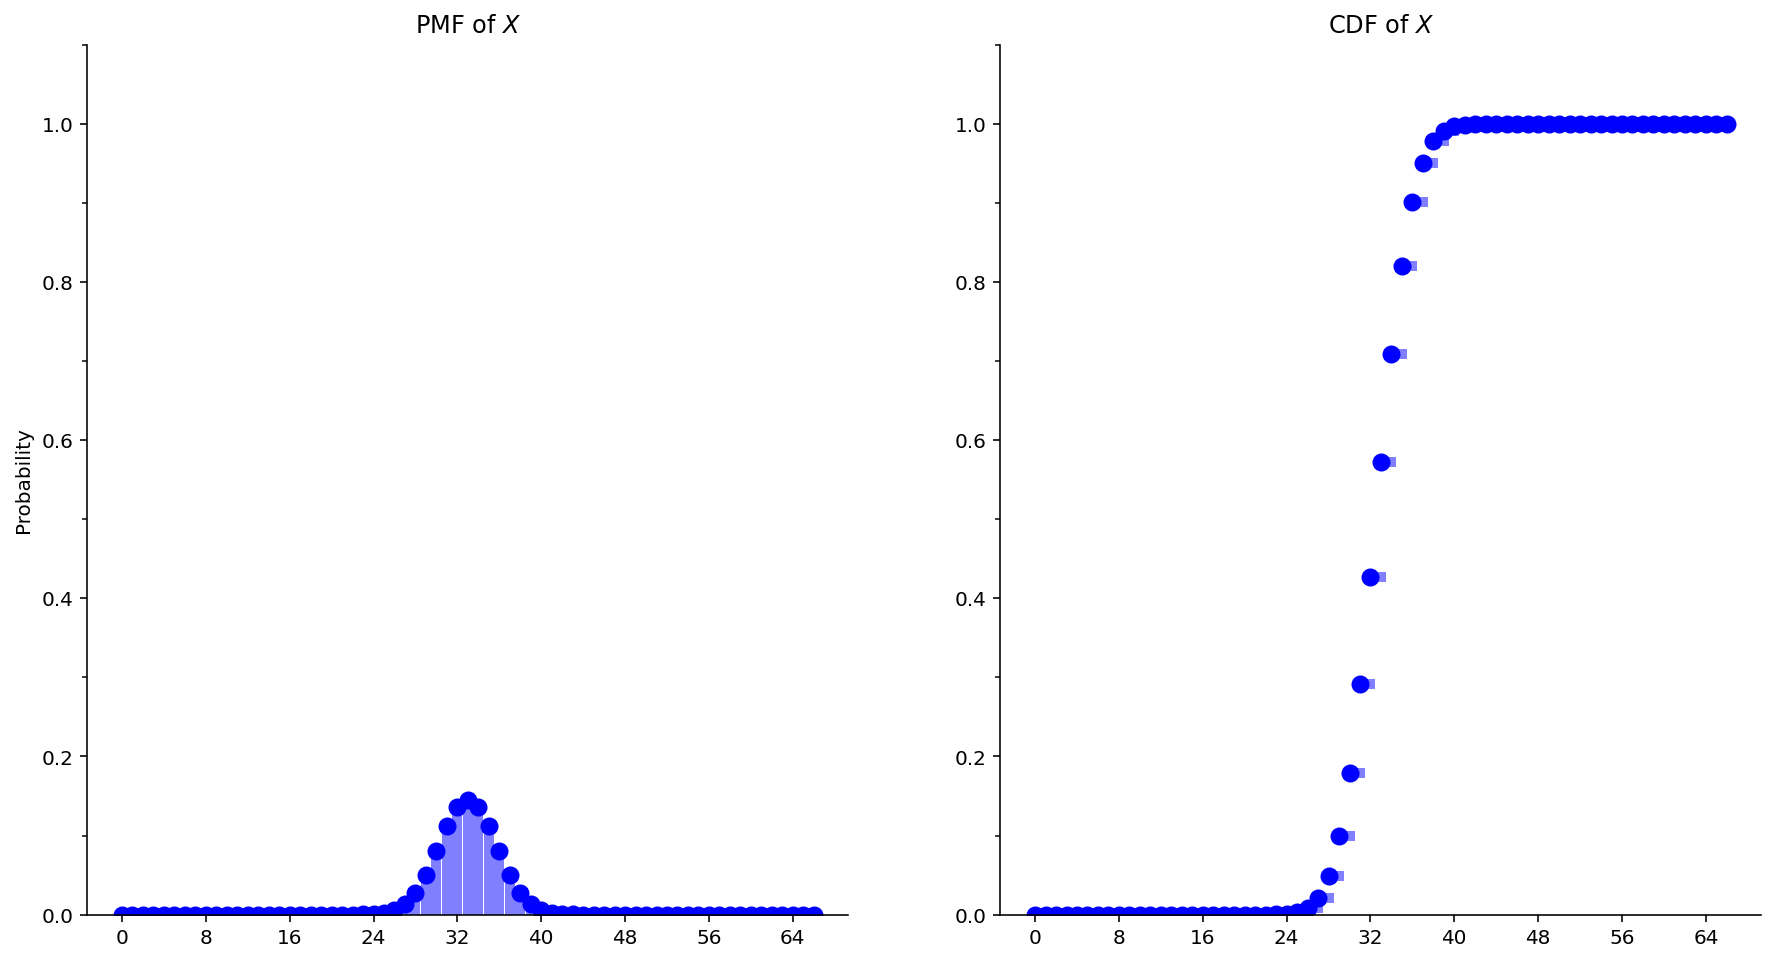

9.588165269199079e-21 probability of Christy contributing 57 or more soup lunches (of 66 soup lunches) if the probabilities of getting soup were the same between Christy and Others


In [28]:
from scipy.stats import hypergeom

# Random variable X is distributed Bin(n,p)
w = 60
w_plus_b = 60+60
n = 66
x = np.arange(0,n+1)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15,8))

for i, ax in enumerate(axes):

    # Plot the PMF
    if i == 0:
        ax.plot(x, hypergeom.pmf(x, w_plus_b, w, n), 'bo', ms=8, label='PMF of $X$')
        ax.vlines(x, 0, hypergeom.pmf(x, w_plus_b, w, n), colors='b', lw=5, alpha=0.5)
        ax.set_ylabel('Probability')
        ax.title.set_text('PMF of $X$')
    else:
        plot_step(x, hypergeom.cdf(x, w_plus_b, w, n), color='b', lw=5, alpha=0.5, label='CDF of $X$')
        for i, prob in enumerate(hypergeom.cdf(x, w_plus_b, w, n)):
            ax.plot(x[i], prob, 'bo', ms=8)
        ax.title.set_text('CDF of $X$')

    # Styling
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_ylim(0, 1.1)
    
    # Axis ticks, labels
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.tick_params(which='minor', width=0.75, length=2.5, labelsize=10)

plt.show()

print(f"{sum(hypergeom.pmf(x, w_plus_b, w, n)[57:])} probability of Christy contributing 57 or more soup lunches (of {n} soup lunches) if the probabilities of getting soup were the same between Christy and Others")

Okay, time to combine all of concepts we've picked up thus far in the lesson: figure out **the mean of a Hypergeometric random variable**.

**Question**:

> Let $X \sim \text{HGeom}(w, b, n)$. What is $E(X)$?

Hint 1: Try to simulate this -- what do you notice? **Submit a PR!**\
Hint 2: Remember, the Binomial and Hypergeometric are related.\
Hint 3: Use indicator random variables.\
Hint 4: Let's go back to our [spreadsheet](https://docs.google.com/spreadsheets/d/1a1y4k6x8ZpKNofz-mdb02tjQOrQJGdyDrHPx9_uxvRI/edit#gid=0).

So far, we've only considered static number of trials and probabilities of success for each trial. Allowing these to go to some *limit*, we can begin to model much more interesting phenomena.

Consider a port, and we define a random variable, $X$, to count the the number of vessels carrying Flexport containers that arrive each hour in a day. (How would we compute the average number of Flexport-laden vessels?)

Now, let $Y$ count the same thing as $X$ except that now we're counting every minute. The probability we see any given vessel of interest is smaller in this given interval, right?

What about $Z$ that does the same as the other random variables, but for every nanosecond? The pattern should hold, right? In any given nanosecond, it's very, very unlikely a boat we're looking to count will come through.

## Exit Ticket ␛

**Question**:

> What happens when I begin to do Bernoulli trials "faster and faster" with the probability of each trial getting smaller and smaller?

Hint 1: Start with $X\sim\text{Bin}(n, p)$. Now increase $n$ and decrease $p$ such that $\lambda$ stays constant (where $\lambda = np$).\
Hint 2: Try to simulate this -- what do you notice? **Submit a PR!**\
Hint 3: Watch the last 10 minutes of our lesson on [Derangements](https://drive.google.com/file/d/1NBG5lqpSOa6JR5mUkNSx0qzhnUltZ39l/view?usp=sharing).